### Load and process flood monitoring data from STAC API - Infrastructure impact

This section loads flood monitoring layers from the GFM STAC API.
We select two key bands: `ensemble_flood_extent` and `exclusion_mask`, and reproject the data to EPSG:4326 to facilitate visualization and spatial analysis.

OpenStreetMap (OSM) data is used to identify bus stops located within a user-defined area (in this case, a region in Pakistan) during a selected flood event.

The analysis highlights potentially impacted bus stops based on the flood extent.  
The script is fully customizable — you can replace the AOI, use a different flood event, or analyze other types of infrastructure from OSM such as hospitals, schools, or roads.



**Import libraries**

In [1]:
import os
from tqdm.notebook import tqdm
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray
import imageio.v2 as imageio
from rasterio.transform import xy
from shapely.geometry import box, mapping
import pyproj
from pystac_client import Client
from odc import stac as stac
from pyrosm import OSM
import folium
import matplotlib.pyplot as plt

**Select area of interests and time period. Find all available data from GFM**

In [2]:
# AOI 
#aoi_geometry = box(6.900787, 50.480729, 7.343674, 50.589837) #Germany
aoi_geometry = box(72.861816, 31.524209, 74.937500, 32.236390) #Pakistan
#aoi_geometry = box(71.913757, 31.476402, 72.976685, 31.927398) #Pakistan smaller

#time_range = ("2021-07-12", "2021-07-19") #Germany
time_range = ("2025-06-26", "2025-07-17") #Pakistan
collection_id = "GFM"

# STAC API
client = Client.open("https://stac.eodc.eu/api/v1")

search = client.search(
    collections=[collection_id],
    intersects=mapping(aoi_geometry),
    datetime=f"{time_range[0]}/{time_range[1]}"
)

items = search.item_collection()
print(f"🔍 Found {len(items)} items.")



🔍 Found 64 items.


**Extract data from GFM**

In [3]:
# Extract the native projection and resolution from the first STAC item
crs = pyproj.CRS.from_wkt(items[0].properties["proj:wkt2"])
resolution = items[0].properties["gsd"]

# Select the bands of interest: flood extent and exclusion mask
bands = ["ensemble_flood_extent", "exclusion_mask"]

# Load STAC items into an xarray dataset
xx = stac.load(
    items,
    crs=crs,                                # Use native CRS from item
    bbox=aoi_geometry.bounds,              # Subset to area of interest
    bands=bands,                           # Load only specified bands
    resolution=resolution,                 # Use native resolution (GSD)
    dtype="uint8",                         # Load data as 8-bit integers
)

# Reproject the dataset to WGS84 (EPSG:4326) for easier visualization and processing
xx = xx.rio.reproject("EPSG:4326")


**Compute Max Flood extent, create exclusion mask and save as .tif**

In [4]:
# Flood
flood_binary = xr.where((xx.ensemble_flood_extent != 255) & (xx.ensemble_flood_extent != 0), 1, 0)
flood_max = xr.where(flood_binary.sum(dim="time") > 0, 1, 0).astype("uint8")
flood_max.rio.to_raster("max_flood_extent.tif", compress="LZW")

# Exclusion
excl_mask = xx.exclusion_mask == 1
excl_max = xr.where(excl_mask.sum(dim="time") > 0, 1, 0).astype("uint8")
excl_max.rio.to_raster("max_exclusion_mask.tif", compress="LZW")

**Plot extracted data**

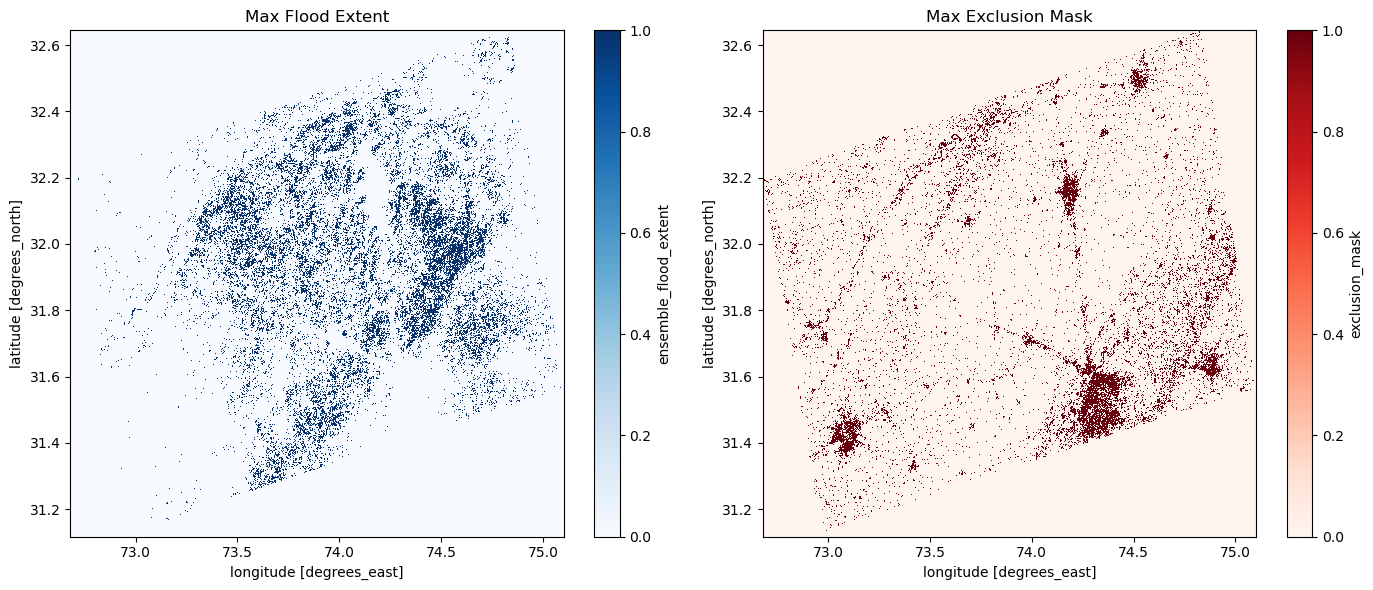

In [5]:
# Show output masks
flood_crop = flood_max
excl_crop = excl_max  

# Plot side by side
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

flood_crop.plot(ax=axs[0], cmap="Blues")
axs[0].set_title("Max Flood Extent")

excl_crop.plot(ax=axs[1], cmap="Reds")
axs[1].set_title("Max Exclusion Mask")

plt.tight_layout()
plt.show()


The most important part here is selecting the correct OSM dataset — in our case, for Pakistan.
Then, we need to extract bus stops (or another infrastructure) from OSM within the area of interest.

**Select and download Open Street Maps data**

In [6]:
# URL and output path for the OSM PBF file
pbf_url = "https://download.geofabrik.de/asia/pakistan-latest.osm.pbf"
pbf_path = "pakistan-latest.osm.pbf"

# Download the .pbf file if it does not already exist
def download_pbf(url, out_path):
    if not os.path.exists(out_path):
        print("🔽 Downloading .pbf file for Pakistan...")
        r = requests.get(url, stream=True)
        with open(out_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
        print("✅ Download complete.")
    else:
        print("🟢 File already exists.")

download_pbf(pbf_url, pbf_path)

# Load the OSM PBF file using Pyrosm
print("📦 Loading PBF file...")
osm = OSM(pbf_path)

# Filter bus stop POIs from the dataset
print("🔍 Extracting bus stops...")
bus_stops = osm.get_pois(custom_filter={"highway": ["bus_stop"]})
bus_stops = bus_stops[bus_stops.geometry.type == "Point"].copy()

# Add longitude and latitude columns
bus_stops["longitude"] = bus_stops.geometry.x
bus_stops["latitude"] = bus_stops.geometry.y

# Filter bus stops within the selected bounding box (from map)
if aoi_geometry:
    bbox = box(*aoi_geometry.bounds)
    bus_stops_bbox = bus_stops[bus_stops.geometry.within(bbox)].copy()
    print(f"📍 Bus stops within AOI: {len(bus_stops_bbox)}")
else:
    raise ValueError("❗ BBOX is not defined. Please run the interactive map and draw the area first.")

# Export the results
bus_stops_bbox.to_file("bus_stops_bbox.gpkg", layer="bus_stops", driver="GPKG")
bus_stops_bbox[['name', 'latitude', 'longitude']].to_csv("bus_stops_bbox.csv", index=False)

print("💾 Outputs saved as bus_stops_bbox.gpkg and bus_stops_bbox.csv")


🟢 File already exists.
📦 Loading PBF file...
🔍 Extracting bus stops...
📍 Bus stops within AOI: 80
💾 Outputs saved as bus_stops_bbox.gpkg and bus_stops_bbox.csv


Now that we have both bus stop locations and flood data, the next step is to analyze whether each bus stop was impacted by flooding.
The area of interest is approximately a 500-meter buffer around each bus stop.

**Analyze data**

In [7]:
# Paths to preprocessed raster masks (GeoTIFF format)
FLOOD_RASTER = "max_flood_extent.tif"
EXCL_RASTER  = "max_exclusion_mask.tif"

# Load rasters into memory (squeezed to 2D)
flood_ds = rioxarray.open_rasterio(FLOOD_RASTER).squeeze()  # (y, x)
excl_ds  = rioxarray.open_rasterio(EXCL_RASTER).squeeze()   # (y, x)

# AOI size (in degrees) for each point buffer (~500 m)
AOI_SIDE = 0.005

def check_point_from_rasters(lat, lon):
    """
    Check flood and exclusion status for a given lat/lon point.
    A square AOI is extracted around the point and used to clip both rasters.
    Returns binary flags (flooded, excluded) and pixel coverage fractions.
    """
    try:
        half = AOI_SIDE / 2
        aoi = box(lon - half, lat - half, lon + half, lat + half)

        flood_crop = flood_ds.rio.clip_box(*aoi.bounds)
        excl_crop  = excl_ds.rio.clip_box(*aoi.bounds)

        if flood_crop.size == 0 or excl_crop.size == 0:
            return {'flood': 0, 'excluded': 0, 'flood_frac': 0.0, 'excluded_frac': 0.0}

        flood_bin = flood_crop == 1
        excl_bin  = excl_crop == 1

        total_pixels = flood_bin.size
        flooded_flag = int(flood_bin.any().item())
        excluded_flag = int(excl_bin.any().item())
        flood_frac = float(flood_bin.sum().item() / total_pixels)
        excl_frac = float(excl_bin.sum().item() / total_pixels)

        return {
            'flood': flooded_flag,
            'excluded': excluded_flag,
            'flood_frac': flood_frac,
            'excluded_frac': excl_frac
        }

    except Exception as e:
        # Optional: log errors to a list instead of printing
        return {'flood': 0, 'excluded': 0, 'flood_frac': 0.0, 'excluded_frac': 0.0}

# Load CSV with facility points (e.g., bus stops) and process each one
INPUT_CSV   = "bus_stops_bbox.csv"
OUTPUT_CSV  = "facilities_flood_exclusion_2024.csv"

df = pd.read_csv(INPUT_CSV)

results = []
for row in tqdm(df.itertuples(index=False), total=len(df), desc="Processing points"):
    result = check_point_from_rasters(row.latitude, row.longitude)
    results.append({
        'name':         getattr(row, 'name', ''),
        'latitude':     row.latitude,
        'longitude':    row.longitude,
        'flood':        result['flood'],
        'excluded':     result['excluded'],
        'flood_pct':    f"{result['flood_frac']*100:.1f}%",
        'excluded_pct': f"{result['excluded_frac']*100:.1f}%",
        'flood_frac':   result['flood_frac']
    })

# Create output DataFrame and export results
out_df = pd.DataFrame(results)
out_df_sorted = out_df.sort_values(by='flood_frac', ascending=False)
out_df_sorted.drop(columns='flood_frac').to_csv(OUTPUT_CSV, index=False)

print(f"✅ Done: Results saved to {OUTPUT_CSV}")

# Display sorted table in notebook (optional)
out_df_sorted.drop(columns='flood_frac').head(20)


Processing points:   0%|          | 0/80 [00:00<?, ?it/s]

✅ Done: Results saved to facilities_flood_exclusion_2024.csv


,name,latitude,longitude,flood,excluded,flood_pct,excluded_pct
37,Kot Abdullah,32.015602,74.539825,1,0,58.2%,0.0%
61,Qila Star Shah Railway Station,31.690411,74.124840,1,1,41.4%,0.6%
43,Baddomalhi-Narowal Morrh,31.889771,74.518990,1,1,40.2%,2.1%
64,Bhalike Railway Station,31.739729,73.703125,1,1,16.2%,0.2%
42,Hachharh,31.998753,74.533348,1,1,16.0%,2.9%
15,Narang Mandi Morr‎,31.919386,74.491234,1,1,15.0%,29.9%
76,نواں شہر بس سٹاپ,32.058628,73.482491,1,1,14.2%,24.5%
78,ٹھٹھہ گاہرہ بس سٹاپ,32.060585,73.501183,1,1,13.9%,8.0%
70,پیلو کھرل بس سٹاپ,32.061096,73.556023,1,1,8.8%,9.1%
65,Rakh Har Sukh Ray,32.046211,73.649033,1,1,8.6%,1.4%


### Table of Flooded Bus Stops

- **name** – Name of the bus stop  
- **latitude / longitude** – Location of the stop  
- **flood** – 1 = affected by flood, 0 = not affected  
- **excluded** – 1 = excluded area, 0 = normal  
- **flood_pct** – % of flooded area within the 500m AOI  
- **excluded_pct** – % of excluded area within the 500m AOI  


**Plot the results on the interactive map**

In [10]:
from PIL import Image
import numpy as np
import folium
import pandas as pd
import geopandas as gpd

# Extract bounding box of the raster (in EPSG:4326 coordinates)
min_lon, min_lat, max_lon, max_lat = xx.ensemble_flood_extent.rio.bounds()
center_lat = (min_lat + max_lat) / 2
center_lon = (min_lon + max_lon) / 2
bounds = [[min_lat, min_lon], [max_lat, max_lon]]

# Load PNG overlay images (exported from rasters) as NumPy arrays
flood_image = np.array(Image.open("max_flood_extent_overlay.png"))
excl_image = np.array(Image.open("max_exclusion_mask_overlay.png"))

# Create a folium web map centered on the raster bounds
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# Add flood extent overlay (blue)
folium.raster_layers.ImageOverlay(
    image=flood_image,
    bounds=bounds,
    mercator_project=True,
    opacity=0.7,
    name="Flood Extent (blue)"
).add_to(m)

# Add exclusion mask overlay (gray)
folium.raster_layers.ImageOverlay(
    image=excl_image,
    bounds=bounds,
    mercator_project=True,
    opacity=0.7,
    name="Exclusion Mask (gray)"
).add_to(m)

# Load analyzed facility points (e.g. bus stops) from CSV
points = pd.read_csv("facilities_flood_exclusion_2024.csv")
gdf = gpd.GeoDataFrame(
    points,
    geometry=gpd.points_from_xy(points.longitude, points.latitude),
    crs="EPSG:4326"
)

# Create a feature group with colored CircleMarkers for each facility
marker_group = folium.FeatureGroup(name="Facilities", show=True)

for _, row in gdf.iterrows():
    # Use red color if flooded, yellow otherwise
    color = "red" if row["flood"] == 1 else "yellow"

    # Create HTML popup with info
    popup_text = f"""<b>{row['name']}</b><br>
    Flooded: {row['flood']}<br>
    Excluded: {row['excluded']}<br>
    Flood %: {row['flood_pct']}<br>
    Excl. %: {row['excluded_pct']}"""

    folium.CircleMarker(
        location=[row.latitude, row.longitude],
        radius=5,
        color="black",
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=popup_text
    ).add_to(marker_group)

# Add the marker layer to the map
marker_group.add_to(m)

# Add layer control for toggling visibility of overlays and markers
folium.LayerControl(collapsed=False).add_to(m)

In [11]:
### 🌐 View interactive flood map

[Click here to open the map](flood_map.html)


SyntaxError: invalid syntax. Perhaps you forgot a comma? (937553096.py, line 3)